# Recurrent Neural Network
This file contains code to run a RNN on the dataset. 

All columns were used and the columns were one hot encoded. There are visualizations to display the model's performance.

The main purpose of the file is to see how another type of model works on the dataset to confirm that the third neural network produced the best results. 

In [ ]:
# Load the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# visualizations
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats
import seaborn as sns
import numpy as np

In [ ]:
# Load the dataset
df = pd.read_csv('hospital_los_21.csv')

In [ ]:
# Define features and target columns
features = [
    "age_group", 
    "gender",
    "type_of_admission", 
    "ccsr_diagnosis_description",
    "ccsr_procedure_description",
    "apr_drg_description",
    "apr_severity_of_illness_description",
    "apr_risk_of_mortality",
    "apr_medical_surgical_description",
    "emergency_department_indicator",
    "apr_mdc_description"
]
target = "length_of_stay"
X = df[features]
y = df[target]


In [ ]:
# One hot encode the categorical columns
preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), features)
        ],
        remainder='drop'
)
X_encoded = preprocessor.fit_transform(X)


In [ ]:
# Split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [6]:
# Reshape for RNN: treat each sample as a sequence of length 1 so input shape becomes (batch, timesteps=1, features)
timesteps = 1
n_feats = X_train.shape[1]

X_train_seq = X_train.reshape((X_train.shape[0], timesteps, n_feats))
X_test_seq = X_test.reshape((X_test.shape[0], timesteps, n_feats))

# Build a simple RNN (LSTM) Model
model = models.Sequential([
    layers.Input(shape=(timesteps, n_feats)),
    layers.LSTM(64), # process the "sequence"
    layers.Dense(32, activation='relu'),
    layers.Dense(1) # regression output
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

# Early stopping callback
early_stop = callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 5, restore_best_weights = True
)

# Train
history = model.fit(
    X_train_seq, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │       317,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,809 (1.22 MB)

 Trainable params: 319,809 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
30454/30454 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - loss: 41.3452 - mae: 3.2820 - val_loss: 38.8004 - val_mae: 3.1016
Epoch 2/20
30454/30454 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - loss: 37.2321 - mae: 3.0898 - val_loss: 37.7757 - val_mae: 3.1030
Epoch 3/20
30454/30454 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - loss: 37.1954 - mae: 3.0740 - val_loss: 37.6225 - val_mae: 3.1002
Epoch 4/20
30454/30454 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 36.0914 - mae: 3.0367 - val_loss: 37.6438 - val_mae: 3.0592
Epoch 5/20
30454/30454 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - loss: 35.7433 - mae: 3.0200 - val_loss: 37.9291 - val_mae: 3.0648
Epoch 6/20
30454/30454 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - loss: 34.9052 - mae: 2.9933 - val_loss: 37.6319 - val_mae: 3.0901
Epoch 7/20
30454/30454 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - loss: 34.5682 - mae: 2.9846 - val_loss: 38.1721 - val_mae: 3.1097
Epoch 8/20
30454/30454 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - loss: 34.3530 - mae: 2.9721 - val_loss: 38.1605 - val_mae: 3.1212



Test MAE: 3.105


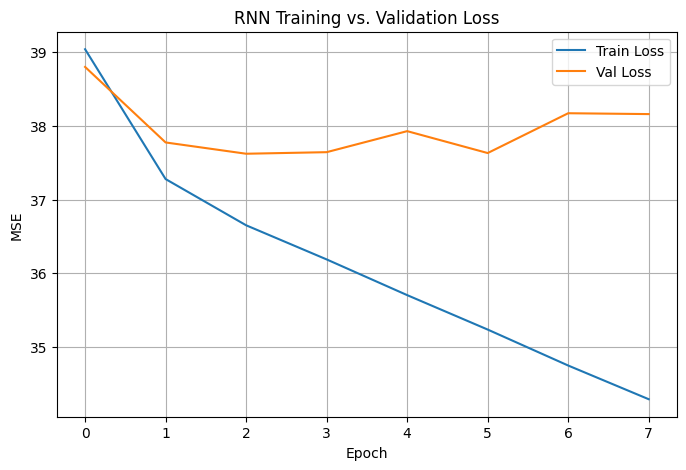

In [ ]:
# Evaluate
test_lost, test_mae = model.evaluate(X_test_seq, y_test, verbose=0)
print(f"\nTest MAE: {test_mae:.3f}")

## Visualization

### Training vs. Validation Loss

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label ='Train Loss')
plt.plot(history.history['val_loss'], label ='Val Loss')
plt.xlabel("Epoch")
plt.ylabel('MSE')
plt.title('RNN Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Actual vs. Predicted

In [1]:
y_pred = model.predict(X_test).flatten()
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Actual Length of Stay')
plt.ylabel('Predicted Length of Stay')
plt.title('Actual vs. Predicted Length of Stay')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

### Splitting up by gender

9517/9517 ━━━━━━━━━━━━━━━━━━━━ 3s 330us/step


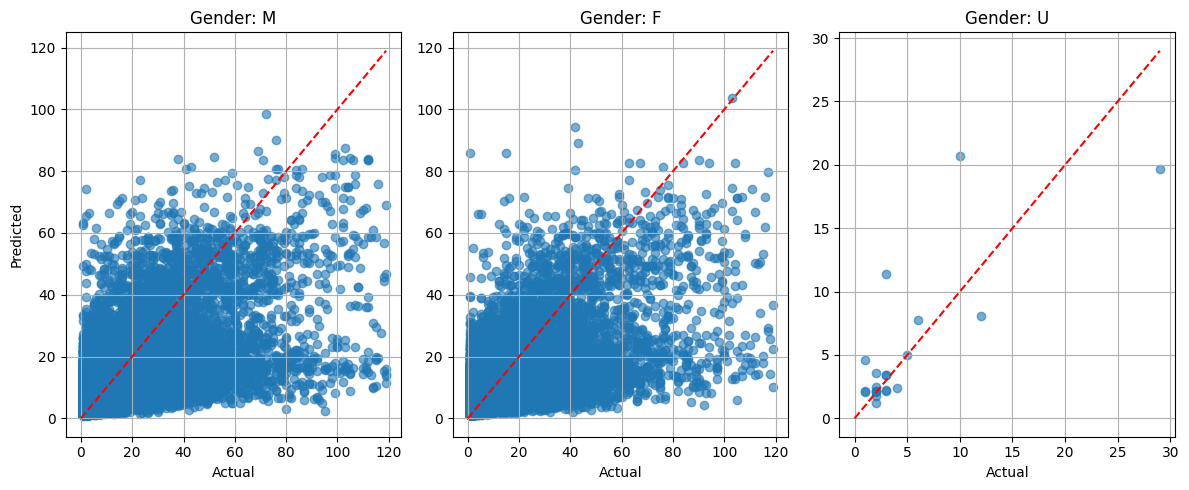

In [ ]:
# 1. Create DataFrame with encoded test features and predictions
X_test_df = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())
X_test_df['y_actual'] = y_test.values
X_test_df['y_pred'] = model.predict(X_test).flatten()
# 2. Add gender values from the original DataFrame
X_test_df['gender'] = df.loc[y_test.index, 'gender'].values.flatten()
# 3. Plot Actual vs Predicted for each gender
genders = X_test_df['gender'].unique()
plt.figure(figsize=(12, 5))
for i, gender in enumerate(genders):
    plt.subplot(1, len(genders), i + 1)
    subset = X_test_df[X_test_df['gender'] == gender]
    plt.scatter(subset['y_actual'], subset['y_pred'], alpha=0.6)
    lims = [0, max(subset['y_actual'].max(), subset['y_pred'].max())]
    plt.plot(lims, lims, 'r--')
    plt.title(f"Gender: {gender}")
    plt.xlabel("Actual")
    if i == 0:
        plt.ylabel("Predicted")
    plt.grid(True)
plt.tight_layout()
plt.show()

### Distribution of residuals

/Users/shailivemuri/VS Code/Hospital LOS/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/shailivemuri/VS Code/Hospital LOS/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/shailivemuri/VS Code/Hospital LOS/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


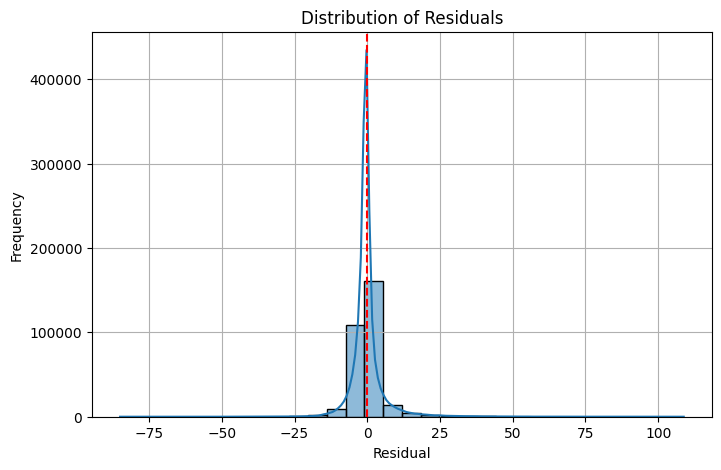

In [ ]:
residuals = X_test_df['y_actual'] - X_test_df['y_pred']
X_test_df['error'] = abs(X_test_df['y_actual'] - X_test_df['y_pred'])
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Error length by bins:

/var/folders/cn/yq8hnccx3n309s8g15blkpv80000gp/T/ipykernel_12542/3093194137.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_bin = X_test_df.groupby('bin')['error'].mean()


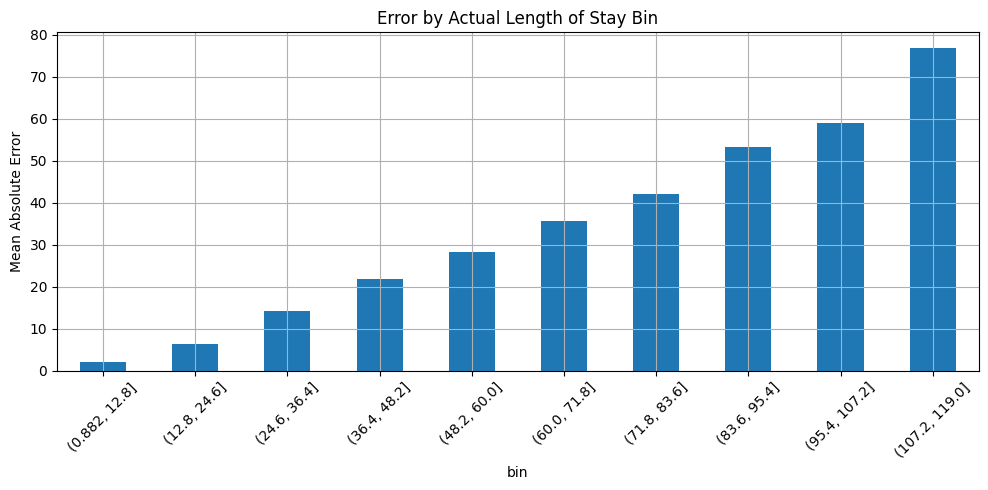

In [ ]:
X_test_df['bin'] = pd.cut(X_test_df['y_actual'], bins=10)
error_by_bin = X_test_df.groupby('bin')['error'].mean()
plt.figure(figsize=(10, 5))
error_by_bin.plot(kind='bar')
plt.ylabel('Mean Absolute Error')
plt.title('Error by Actual Length of Stay Bin')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### QQ Residual Plot

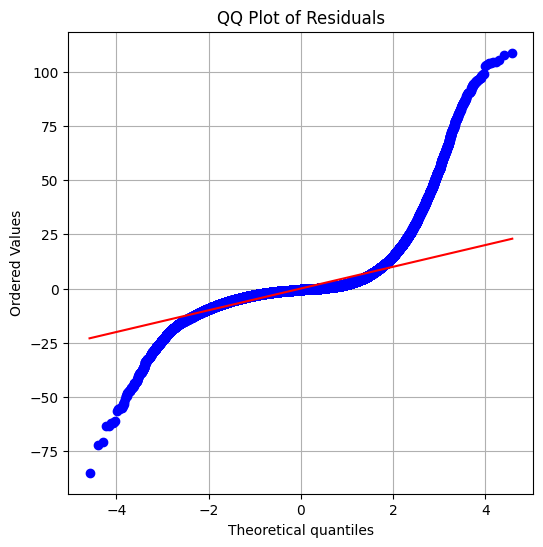

In [ ]:
import scipy.stats as stats
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.show()

### Splitting up by age group

9517/9517 ━━━━━━━━━━━━━━━━━━━━ 3s 334us/step


/var/folders/cn/yq8hnccx3n309s8g15blkpv80000gp/T/ipykernel_12542/3716347922.py:21: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


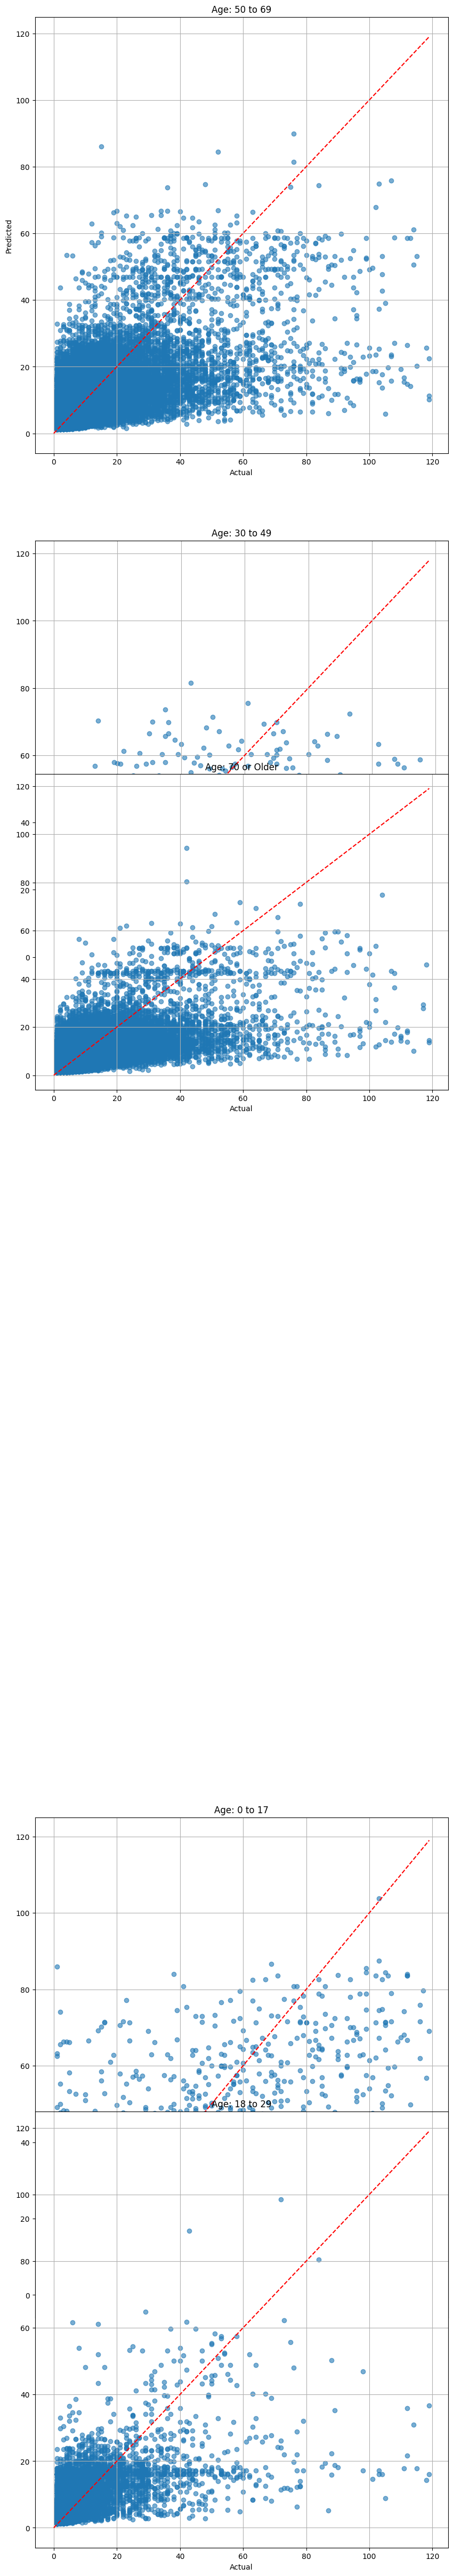

In [ ]:
# 1. Create DataFrame with encoded test features and predictions
X_test_df = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())
X_test_df['y_actual'] = y_test.values
X_test_df['y_pred'] = model.predict(X_test).flatten()
# 2. Add gender values from the original DataFrame
X_test_df['age_group'] = df.loc[y_test.index, 'age_group'].values.flatten()
# 3. Plot Actual vs Predicted for each gender
age_groups = X_test_df['age_group'].unique()
plt.figure(figsize=(10, 100))
for i, age_group in enumerate(age_groups):
    plt.subplot(len(age_group), 1 ,i + 1)
    subset = X_test_df[X_test_df['age_group'] == age_group]
    plt.scatter(subset['y_actual'], subset['y_pred'], alpha=0.6)
    lims = [0, max(subset['y_actual'].max(), subset['y_pred'].max())]
    plt.plot(lims, lims, 'r--')
    plt.title(f"Age: {age_group}")
    plt.xlabel("Actual")
    if i == 0:
        plt.ylabel("Predicted")
    plt.grid(True)
plt.tight_layout()
plt.show()

### Getting MAE Per Age Group

In [ ]:
# Getting MAE per age_group: 

for age_group in age_groups:
    subset = X_test_df[X_test_df['age_group'] == age_group]
    mae = mean_absolute_error(subset['y_actual'], subset['y_pred'])
    print(f"MAE for age_group {age_group}: {mae:.2f}")


MAE for age_group 50 to 69: 3.72
MAE for age_group 30 to 49: 2.46
MAE for age_group 70 or Older: 3.85
MAE for age_group 0 to 17: 1.99
MAE for age_group 18 to 29: 2.13
